# 1 Data

The first step is to acquire the data we will be working on. Each file we will use (see https://snap.stanford.edu/data/sx-stackoverflow.html) are:
- `a2q`: Answers to questions - User `u` answered user `v`'s question a\t time `t`
- `c2a`: Comments to questions - User `u` commented on user `v`'s question at time `t`
- `c2q`: Comments to answers - User `u` commented on user `v`'s answer at time `t`

Those files will be interpreted as (weighted) graphs and then merged together. Since the dates are provided with a very high precision we will round it to a reasonable value (e.g. day, hours). Moreover, since the data is a lot we will only focus on a smaller intrerval of time. 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import networkx as nx
import csv
import functionalities
import math
import datetime, time

### Read files as Pandas' dataframes and add a new "type" column and a new "weights" column to the datasets

In [2]:
# EXECUTE ONLY ONCE
# REMARK: The execution of this cell can take a few seconds

a2q = pd.read_csv('sx-stackoverflow-a2q.txt', sep = " ", names = ['u','v','t'])  
a2q['type'] = 'a2q'
a2q['weight'] = 0.5

In [3]:
# EXECUTE ONLY ONCE
# REMARK: The execution of this cell can take a few seconds

c2a = pd.read_csv('sx-stackoverflow-c2a.txt', sep=" ", names = ['u','v','t'])
c2a['type'] = 'c2a'
c2a['weight'] = 0.2

In [4]:
# EXECUTE ONLY ONCE
# REMARK: The execution of this cell can take a few seconds

c2q = pd.read_csv('sx-stackoverflow-c2q.txt', sep=" ", names = ['u','v','t']) 
c2q['type'] = 'c2q'
c2q['weight'] = 0.35

### Get time interval

In [5]:
files = [a2q, c2a, c2q]

# in unix timestamps 2021/12/05 00:00 corresponds to 1638662400 
inf = 1638662400 
sup = 0

time_interval = list(functionalities.get_time_interval(files, inf, sup))

In [6]:
print("First timestamp corresponds to:",datetime.datetime.fromtimestamp(time_interval[0]).strftime("%Y-%m-%d"),sep=" ")
print("Last timestamp corresponds to:",datetime.datetime.fromtimestamp(time_interval[1]).strftime("%Y-%m-%d"),sep=" ")

First timestamp corresponds to: 2008-08-01
Last timestamp corresponds to: 2016-03-06


**Remark .** We will choose to study the time interval (01-01-2010, 07-01-2010). See for example https://www.epochconverter.com

In [7]:
time_interval = [1262304000,1263081600]
end = datetime.datetime.fromtimestamp(time_interval[1]).strftime("%Y-%m-%d")
start = datetime.datetime.fromtimestamp(time_interval[0]).strftime("%Y-%m-%d")
print(f'our time interval is from {start} to {end}')

our time interval is from 2010-01-01 to 2010-01-10


### Create graphs

In [8]:
def graph_builder(df,time_interval):
    """
    Function that builds a graph given a pandas dataframe 
    
    INPUT: df, time_interval: a pandas dataframe and a list of integers, respectively
    Output: G, a networkx DiGraph object
    """
    # initialization
    G = nx.Graph()
    
    # cancel loops 
    df = df[df['u'] != df['v']]
    
    # cancel elements exceeding time bounds
    df = df[df['t'].between(time_interval[0], time_interval[1])]
    
    #adding weights column to the dataframe
    df = functionalities.weighter(df)
    
    # See https://www.kite.com/python/docs/networkx.from_pandas_edgelist
    G = nx.from_pandas_edgelist(df, 'u', 'v', ['t', 'type', 'weight'], create_using = nx.DiGraph())

    return G

In [9]:
# EXECUTE ONLY ONCE
# REMARK: The execution of this cell can take a few second

G_a2q = nx.DiGraph()
G_a2q = graph_builder(a2q, time_interval)
G_c2a = graph_builder(c2a, time_interval)
G_c2q = graph_builder(c2q, time_interval)

In [10]:
# Uncomment the following lines to inspect the graphs just created

# G_a2q.edges.data("weight", default=1)
# G_c2a.edges.data("weight", default=1)
# G_c2q.edges.data("weight", default=1)

### Merging 

In [11]:
G = nx.compose(G_a2q, G_c2a)
G = nx.compose(G, G_c2q)

In [12]:
# check
print(len(G_a2q.edges()) + len(G_c2a.edges()) + len(G_c2q.edges()))
print(len(G.edges()))

51658
50075


In [13]:
# check
df = pd.DataFrame(G.edges.data("weight", default=1))
df.head()

,0,1,2
0,144424,102398,0.576
1,144424,184273,0.576
2,144424,108714,0.576
3,144424,242225,0.576
4,144424,62138,0.576


# 2 Implementation of the backend

The goal of this part is the implementation of a unique system that has different functionalities. The program takes in input always a positive integer `i`: given the input, the program has to run Functionality `i`, applied to the graph created before.

**Remark.** Most of the functions we will need for this and the next part (e.g. the function `distance` that calculates the shortest path between two nodes) are available in the `functionalities.py` file (here imported as `functionalities`).

## Functionality 1 - Get the overall features of the graph
It takes in input: 
- One of the 3 graphs

It outputs:
- Whether the graph is directed or not
- Number of users
- Number of answers/comments
- Average number of links per user
- Density degree of the graph
- Whether the graph is sparse or dense

**Remark .** We will say that the graphs are always directed. Indeed there is a "natural" direction given by the flow of time. If there is an edge between two users it means that there was an interaction among them, so if user `a` comments or answers a user `b` this means that `b` posted something that `a` can answer to or comment to, so the edge between `a` and `b` will be oriented from `b` to `a`.

In [14]:
def F1(G):
    features = [] 

    directed = "yes"
        
    # number of interactions (answers or comments)
    tot_interactions = len(G.edges())
    
    # number of users
    tot_users = len(G.nodes())
    
    # average number of links and density
    avg_links = 0
    density = 0
    if tot_users: 
        
        # average number of links
        avg_links = tot_interactions/tot_users
        
        # density
        # see https://en.wikipedia.org/wiki/Dense_graph
        if directed == "yes":
            density = 2*tot_interactions/(tot_users*(tot_users-1))
        else:
            density = tot_interactions/(tot_users*(tot_users-1))
        
        dense = None
        
        # see https://stackoverflow.com/questions/12599143
        if G.number_of_edges() >= int(G.number_of_nodes()*math.log(G.number_of_nodes())):
            dense = "yes"
        else:
            dense ='no'

    features.append((directed, tot_users, tot_interactions, avg_links, density, dense))
    return features

In [15]:
# check
graphs = [G_a2q, G_c2a, G_c2q]
for graph in graphs:
    print(F1(graph))

[('yes', 13246, 26030, 1.9651215461271327, 0.0002967340953004353, 'no')]
[('yes', 9704, 18407, 1.8968466611706514, 0.00039098148225716816, 'no')]
[('yes', 5404, 7221, 1.3362324204293117, 0.0004946261041752033, 'no')]


## Functionality 2 - Find the best users!

Functionality 2 takes in input:
- A user/node
- An interval of time
- One of the following metrics: Betweeness, PageRank, Closeness, Centrality, DegreeCentrality

The output should return:
- The value of the given metric applied over the complete graph for the given interval of time

**Remark .** Most of the definitions used in the following are taken from here: http://aris.me/contents/teaching/data-mining-ds-2015/resources/graphs.pdf. In particular:
- Given a graph $G=(V,E)$, the *centrality* of a node $v$ is just its degree.
- The *degree centrality* of a node $v$ with degree $deg(v)$ is given by $deg(v)\cdot (|V|-1)^{-1}$
- The *betweeness* of a node $v$ is given by $$\sum_{u,w} \frac{g_{u,w}^v/g_{u,w}}{{{n-1} \choose {2}}} $$ where the sum runs over $V\setminus\{v\}$ and $g_{u,w}^v$ is the number of shortest paths between the 2 nodes (u,w) passing through v, similarly $g_{u,w}$ is the number of shortest paths between the 2 nodes (u,w),
- The *Page Rank* of a page $P_i$ is equal to $\frac{(1 - damping factor)}{Number Of Pages} + damping factor * (\sum$ of each page $P_{j}$’s $PageRank)$, where $P_j$ links to $P_i$, divided over the number of outbound links of $P_j$. Moreover $PR(p_i) = \frac{1-d}{N} + d \sum_{(p_j \in M(p_i))} \frac{PR(p_j)}{L(p_j)}$ where $p_{1},p_{2},...,p_{N}$ are the pages under consideration, $M(p_{i})$ is the set of pages that link to $p_{i}$, $L(p_{j})$ is the number of outbound links on page $p_{j}$, and $N$ is the total number of pages

In [16]:
# Example
print(functionalities.centrality(G,68150))

1


In [17]:
# Example
print(functionalities.closeness(G,68150))

100%|██████████| 15410/15410 [00:00<00:00, 390850.86it/s]

7704.5


In [18]:
# Example
print(functionalities.distance(G,144424,102398))

(2, [144424, 102398])


In [19]:
def F2(G, v, metric): 
    if metric == 'Betweeness':
        print("Keep calm, this functions takes a long long time!")
        return functionalities.betweeness(G,v)
    
    elif metric == 'PageRank':
        return functionalities.page_rank(G, d = 0.85, iters = 10)
    
    elif metric == 'Closeness':
        print("Keep calm, this functions takes a long long time!")
        return functionalities.closeness(G,v)
        
    elif metric == 'Centrality':
        return functionalities.centrality(G,v)
    
    elif metric == 'Degree Centrality':
        return functionalities.degree_centrality(G,v)
    else:
        print("Invalid metric")

In [20]:
# Example
F2(G, 144424, "Centrality")

41

## Functionality 3

It takes in input:
- A sequence of users p = [p_2, ..., p_n-1]
- Initial user p_1 and an end user p_n


Implement an algorithm that returns the shortest walk that goes from user p_j to p_n, and that visits in order the nodes in p. 

**Remark.** We don't need to specify the time interval since this is implicit in the definition of the graphs we are using


In [21]:
def F3(G,users,start,end):
    s_p = functionalities.distance(G,start,users[0]) # or dijkstra
    dist = s_p[0]
    path = s_p[1]
    
    if dist == -1:
        return False
    
    for i in range(len(users)-1):
        s_p = functionalities.distance(G,users[i],users[i+1])
        if s_p[0] == -1:
            return False
        dist += s_p[0]
        path.append(s_p[1][1:])
        
    s_p = functionalities.distance(G,users[-1],end)
    if s_p[0] == -1:
            return False
        
    dist += s_p[0]
    path.extend(s_p[1][1:]) 
    
    return dist,path

## Functionality 4

It takes in input:

- Two different intervals of time (disjoint or not), which will lead to two different graphs, G_1 (associated to interval 1) and G_2 (associated to interval 2)
- Two users which are unique to each interval of time (user_1 only appears in interval 1, while user_2 only appears in interval 2)

The function returns the minimum number of links (considering their weights) required to disconnect the two users.

In [22]:
def dr_e(G,time):
    drop=[]
    time=(time[0],time[1])

    for u,v,t in G.edges(data=True):
        if not time[0] <= t['t'] <= time[1]:
            drop.append((u, v))
    [G.remove_edge(u,v) for (u,v) in drop]
    return G

In [23]:
def F4(G,time_interval_1,time_interval_2,u1,u2):
    g1 = G.copy()
    g2 = G.copy()
    _g1 = dr_e(g1,time_interval_1)
    _g2 = dr_e(g2,time_interval_2)
    graph_total = nx.compose(_g1,_g2)
    path = functionalities.distance(graph_total,u1,u2)[1]
    

    if path == []:
        return 'Nodes are not connected'
    weight = 0
    n_l = 0
    link_e = (path[0],path[1])
    edges_disc = []
    while path != []:
        min_weight = math.inf
        for i in range(len(path)-1):
            j = i + 1
            if graph_total[path[i]][path[j]]['weight'] < min_weight:
                min_weight = graph_total[path[i]][path[j]]['weight']
                link_e = (path[i],path[j])
        weight += min_weight
        n_l += 1
        edges_disc.append(link_e)
        #print(link_e)
        graph_total.remove_edge(link_e[0],link_e[1])
        path = functionalities.distance(graph_total,u1,u2)[1]
        
    print('Links to cut(min): ' +  str(n_l) + ', Total weight:' + str(weight))
    
    return edges_disc

In [24]:
# Example
time_interval1 = [1262304000,1262504000]
time_interval2 = [1262504000,1262604000]
u1 = 61974
u2 = 3333
F4(G,time_interval1,time_interval2,u1,u2)

Links to cut(min): 10, Total weight:2.229


[(185944, 3333),
 (50394, 3333),
 (8206, 238704),
 (572, 238704),
 (218978, 3333),
 (203104, 238704),
 (209359, 238704),
 (79909, 14148),
 (39742, 3333),
 (13422, 2509)]

# 3 Implemantation of the Frontend

We will build visualizations for users' queries results.

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Visualization 1 - Visualize the overall features of the graph

Output a table with all of the information requested. The visualization also generates a plot of the density distribution of the graph provided as input.

In [26]:
col_1 = pd.DataFrame(["directed ?", "number of users:", "number of answers/comments", "average number of links per user:",\
                      "density degree", "dense ?"])
col_2 = pd.DataFrame(F1(G_a2q)).T

In [27]:
frames = [col_1,col_2]
pd.concat(frames, axis =1)

,0,0
0,directed ?,yes
1,number of users:,13246
2,number of answers/comments,26030
3,average number of links per user:,1.965122
4,density degree,0.000297
5,dense ?,no


In [28]:
def V1(G):
    name = ""
    if G==G_a2q:
        name = "G_a2q"
    elif G==G_c2q:
        name = "G_c2q"
    else:
        name = "G_c2a"
    plt.figure(figsize=(20, 6))
    degrees = [functionalities.centrality(G,v) for v in G.nodes()]
    plt.title(f'Degree Distribution of {name}')
    plt.hist(degrees, bins=500, range=(0,40))
    plt.show()

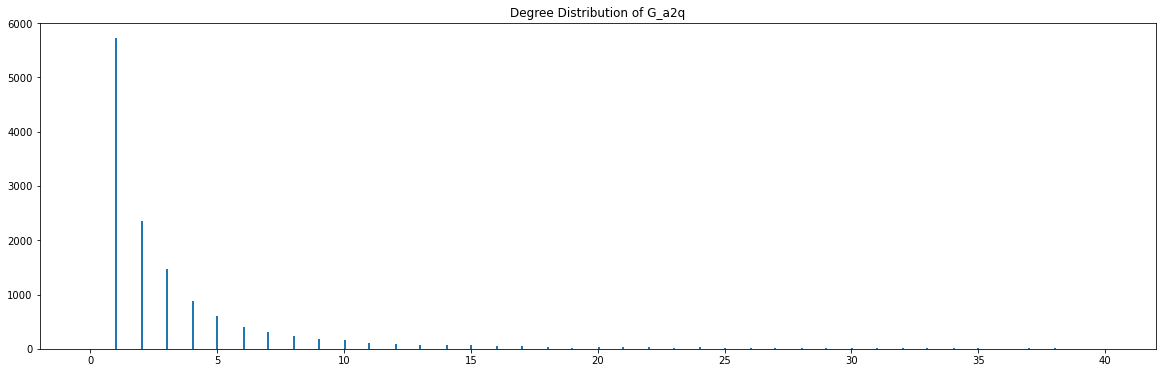

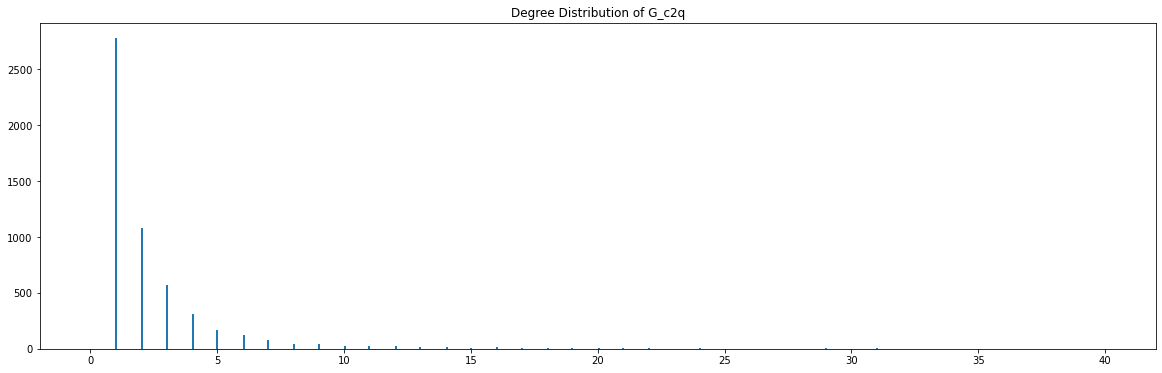

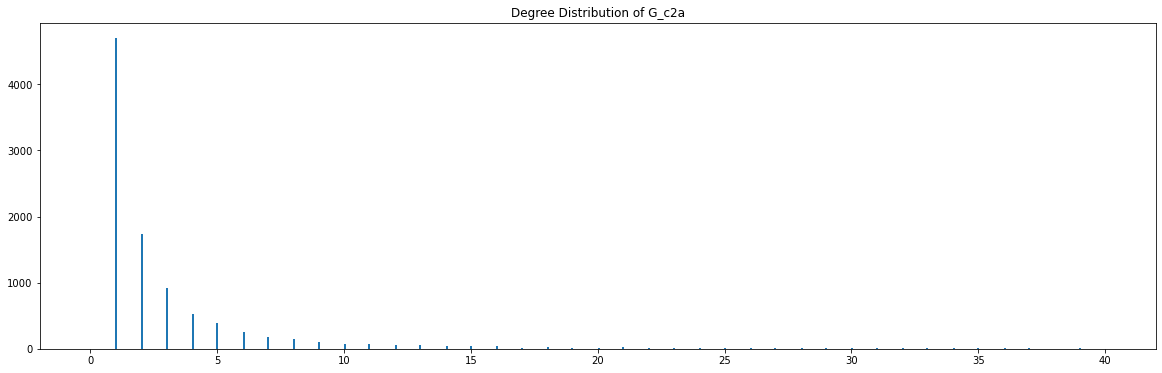

In [29]:
for G in [G_a2q, G_c2q, G_c2a]:
    V1(G)

## Visualization 2

Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.

In [30]:
def V2(Graph, node, time_interval):
    G_new = nx.Graph()
    
    #edges where 'node' is the predecessor
    edges_pred = [(u,v,d) for u,v,d in Graph.edges(data = True) if u == node]
    
    
    #edges where 'node' is the successor
    edges_succ = [(u,v,d) for u,v,d in Graph.edges(data = True) if v == node]
    
    G_new.add_edges_from(edges_pred)
    G_new.add_edges_from(edges_succ)
    
    G1, G2, G3, G4 = functionalities.time_splitter(G_new, time_interval)
    
    edges1 = G1.edges()
    weights1 = [G1[u][v]['weight'] for u,v in edges1]
    weights1 = [w*6 for w in weights1]

    edges2 = G2.edges()
    weights2 = [G2[u][v]['weight'] for u,v in edges2]
    weights2 = [w*6 for w in weights2]
    
    edges3= G3.edges()
    weights3 = [G3[u][v]['weight'] for u,v in edges3]
    weights3 = [w*6 for w in weights3]
    
    edges4= G4.edges()
    weights4 = [G4[u][v]['weight'] for u,v in edges4]
    weights4 = [w*6 for w in weights4]
    
    #then the visual representation
    figure(figsize=(10, 10), dpi=80)
    
    
    plt.subplot(221) 
    plt.title('First interval')
    nx.draw(G1, width=weights1, with_labels=True, node_color="blue",
            edgecolors = 'orange', node_size = 500, alpha = 0.9)    
    
    plt.subplot(222)
    plt.title('Second interval')
    nx.draw(G2, width=weights2, with_labels=True, node_color="violet", 
            edgecolors = 'orange', node_size = 500, alpha = 0.9)    
    
    plt.subplot(223)
    plt.title('Third interval')
    nx.draw(G3, width=weights3, with_labels=True, node_color="green",
            edgecolors = 'orange', node_size = 500, alpha = 0.9)
    
    plt.subplot(224)
    plt.title('Fourth interval')
    nx.draw(G4, width=weights4, with_labels=True, node_color="orange",
            edgecolors = 'orange', node_size = 500, alpha = 0.9)
    
    plt.draw()

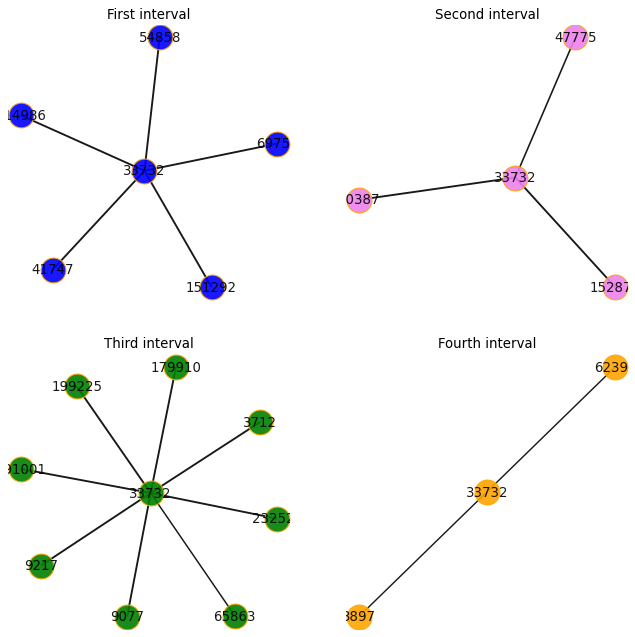

In [31]:
# Example
V2(G, 33732, time_interval)

## Visualization 3

Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.

In [32]:
def V3(G, users, start, end):
    #we pick only the sequence of nodes generated (it's a list)
    edges = F3(G, users, start, end)[1] 
    
    edge_list = []
    
    #we create a list of every edge between 'start' and 'end'
    for i in range(len(edges)-1):
        edge_list.append((edges[i], edges[i+1]))
    
    figure(figsize=(10, 10), dpi=80)
    G_new = G.edge_subgraph(edge_list)
    
    #we extract the weights from the graph to ponder the edges
    weights = [G_new[u][v]['weight'] for u,v in G_new.edges()]
    weights = [w*4 for w in weights]
    plt.title('The shortest path between the users '+str(start)+' and '+str(end)+', passing by '+str(users))
    
    nx.draw(G_new, with_labels = True, node_color="orange", width=weights)

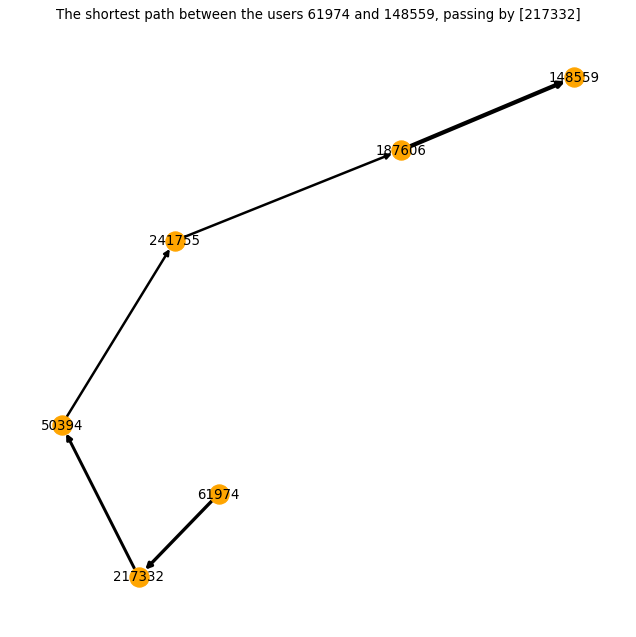

In [33]:
# Example
V3(G_a2q, [217332], 61974, 148559)

## Visualization 4

Show a visualization of the links needed to be removed in order to disconnect both graphs.

In [34]:
def V4(G, time_interval1, time_interval2, u1, u2):    
    #by using the functionality 4, we extract the edges that we need to cut to separate the two graphs
    edges_cut = F4(G,time_interval1,time_interval2,u1,u2)

    G_new = G.edge_subgraph(edges_cut)

    pos = nx.shell_layout(G_new)
    
    figure(figsize=(10, 10), dpi=80)
    
    #we extract and ponder the weights as we did in the previous visualizations
    weights = [G_new[u][v]['weight'] for u,v in G_new.edges()]
    weights = [w*4 for w in weights]
    plt.title("All the required links to disconnect the two graphs")

    nx.draw(G_new, with_labels = True, node_color="orange", width=weights, pos = pos)
    
    plt.draw()

Links to cut(min): 3, Total weight:0.712


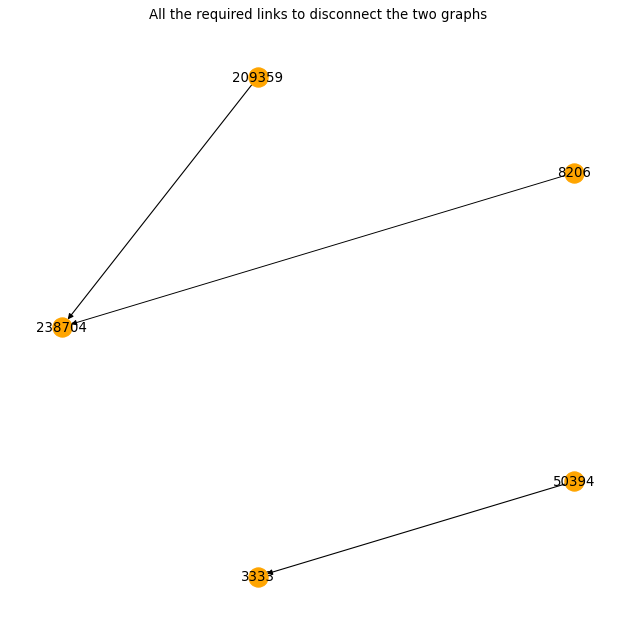

In [35]:
# Example
V4(G, time_interval1,time_interval2,u1,u2)

# 4 Algorithmic question

A number $n$ of kids are in a camp. Between some $k$ pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

We propose an algorithm that is linear in $n$ and $k$ (there are two for cycles in $k$ and one in $n$ so $T(n)=2O(k)+O(n)+O(1)$) that is able to answer whether such an assignment is possible and, if so, return one.

The idea is as follows:
- sort the couples in k and enumerate the kids as $1,2,\dots, n$
- for each $(a,b)$ in one of the $k$ pairs, assign a to the first dormitory and $b$ to the second dormitory;
- then for each remaining kid assign it (for example) to the first dormitory 
- check in each dormitory if there are couples in k, if there are the problem will not have solution

In [36]:
def exchange(tup): 
    """
    Function to sort a couple's components
    """
    if tup[0] > tup[1]:
        tup = list(tup) 
        _ = tup[0]
        tup[0] = tup[1]
        tup[1] = _
        return tuple(tup)
    else:
        return tup

In [37]:
def algo(n, k): 
    """
    Proposed algorithm
    """
    
    # dormitories
    n = range(1,n+1)
    dorm_1 = [] 
    dorm_2 = [] 
    
    # kids already assigned
    checked = [] 
    
    # counter
    count = 0
    
    for pair in k:
        # order pair components
        pair = exchange(pair)
        
        # add non assigned kids (taken from pair[0]) to dorm_1
        if checked.count(pair[0]) == 0: 
            checked.append(pair[0]) 
            dorm_1.append(pair[0]) 
        
        # add non assigned kids (taken from pair[1]) to dorm_2
        if checked.count(pair[1]) == 0: 
            dorm_2.append(pair[1]) 
            checked.append(pair[1]) 
    
    # assign all the remaining kids (that are not in k)
    for kid in n: 
        if (dorm_1.count(kid) == 0) and (dorm_2.count(kid) == 0):
            dorm_1.append(kid) 
    
    for i in k: 
        # check if a couple of k is in the same dormitory
        # in such a case increment count 
        # Remark: if count is non zero the problem has no solution
        boolean = ((dorm_1.count(i[0]) != 0) and (dorm_1.count(i[1]) != 0)) or \
        ((dorm_2.count(i[0]) != 0) and (dorm_2.count(i[1]) != 0))
        
        if boolean:
            count += 1
            
    if count:
        print("The problem has no solution")
        
    else:
        print("dorm_1", dorm_1)
        print("dorm_2", dorm_2)
    

## Some Examples

In [38]:
k = [(1,2)]
n = 5
algo(n,k)

dorm_1 [1, 3, 4, 5]
dorm_2 [2]


In [39]:
k = [(1,2),(3,5),(4,6),(1,10)]
n = 10
algo(n,k)

dorm_1 [1, 3, 4, 7, 8, 9]
dorm_2 [2, 5, 6, 10]


In [40]:
k = [(1,2),(2,3),(3,1)]
n = 6
algo(n,k)

The problem has no solution


**Remark .** Why do we need to sort the $k$ pairs first? Well, consider the following counterexample
- $k = \{(1,2),(3,1)\}$
- $n = 5$

Then, without the initial sorting, the algorithm wouldn't find a solution (to verify it comment the line `pair = exchange(pair)`), but by a direct calculation we see that 

`dorm_1=[1,4,5]`

`dorm_2 = [2,3]` 

is a solution. Indeed, without the initial sorting the kid labled with 1 cannot be assigned to any dormitory.